# `streamline_horses_featurization_trainer.ipynb`

### Author: Anthony Hein

#### Last updated: 11/3/2021

# Overview:

Perform feature engineering on the horses dataset to summarize the past performance of any given horse.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `horses_selected_trimmed_clean_augmented.csv`

We will perform calculations with this dataset since it is slimmer, even though we will eventually concatenate our features to the dataset which already contains the features for a horse.

In [3]:
horses_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_selected_trimmed_clean_augmented.csv", low_memory=False) 
horses_clean.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,OR,father,mother,gfather,weight,res_win,res_place,res_show,finishing time,finishing time ratio
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,NaN,King's Ride,Browne's Return,Deep Run,73,1,1,0,277.200000,1.000000
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,NaN,Long Pond,Courtlough Lady,Giolla Mear,73,0,1,0,278.679948,1.005339
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,NaN,Nordico,Over The Seas,North Summit,71,0,0,0,278.957438,1.006340
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,Roselier,Miss Reindeer,Reindeer,73,0,0,0,284.507242,1.026361
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,Noalto,Elena's Beauty,Tarqogan,66,0,0,0,290.057045,1.046382


In [4]:
horses_clean.shape

(202304, 24)

---

## Load `horses_featurized_horse.csv`

We need to join any new features to this.

In [5]:
horses_featurized_horse = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_featurized_horse.csv", low_memory=False) 
horses_featurized_horse.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,prev_3_position_rain,prev_1_finishing_time_ratio_rain,prev_2_finishing_time_ratio_rain,prev_3_finishing_time_ratio_rain,prev_1_position_rhum,prev_2_position_rhum,prev_3_position_rhum,prev_1_finishing_time_ratio_rhum,prev_2_finishing_time_ratio_rhum,prev_3_finishing_time_ratio_rhum
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
horses_featurized_horse.shape

(202304, 90)

In [7]:
horses_featurized_horse_jockey = horses_featurized_horse.copy()
horses_featurized_horse_jockey.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,prev_3_position_rain,prev_1_finishing_time_ratio_rain,prev_2_finishing_time_ratio_rain,prev_3_finishing_time_ratio_rain,prev_1_position_rhum,prev_2_position_rhum,prev_3_position_rhum,prev_1_finishing_time_ratio_rhum,prev_2_finishing_time_ratio_rhum,prev_3_finishing_time_ratio_rhum
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

## Load `races_featurized.csv`

In [8]:
races_featurized = pd.read_csv(f"{BASE_DIR}/data/streamline/races_featurized.csv", low_memory=False) 
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,1,0,0,0,0,0,0,1,1.350363
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,1,0,0,1,0,0,0,0,1,1.995151
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,1,0,0,0,0,0,0,1,0,1.786421
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,1,0,0,0,0,0,1,0,1.611062
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,1,0,0,0,0,0,1,0,0,1.254374


In [9]:
races_featurized.shape

(20201, 129)

In [10]:
races_featurized['datetime'] = pd.to_datetime(races_featurized['datetime'])
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,1,0,0,0,0,0,0,1,1.350363
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,1,0,0,1,0,0,0,0,1,1.995151
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,1,0,0,0,0,0,0,1,0,1.786421
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,1,0,0,0,0,0,1,0,1.611062
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,1,0,0,0,0,0,1,0,0,1.254374


In [11]:
races_featurized = races_featurized.sort_values(by='datetime')
races_featurized[['datetime']].head(10)

,datetime
320,1990-01-20 14:30:00
321,1990-05-18 17:30:00
322,1990-05-18 18:30:00
323,1990-05-25 17:00:00
324,1990-05-28 18:30:00
325,1990-07-11 17:00:00
326,1990-07-20 18:00:00
328,1990-08-14 17:15:00
327,1990-08-14 18:45:00
329,1990-08-16 17:15:00


---

## Exploring Trainer

In [12]:
horses_clean['trainerName'].value_counts()

A P O'Brien           8089
D K Weld              7735
J S Bolger            7450
M Halford             5419
G M Lyons             4704
                      ... 
Eugene Cleary            1
Ms Deborah J Evans       1
Howard Johnson           1
D J Daly                 1
Michael Gainford         1
Name: trainerName, Length: 1774, dtype: int64

In [13]:
horses_clean['trainerName'].value_counts()[:1000]

A P O'Brien              8089
D K Weld                 7735
J S Bolger               7450
M Halford                5419
G M Lyons                4704
                         ... 
N P Walsh                   8
John Stephen Cullen         8
Mark Hayden                 8
P Hogan                     8
David Anthony O'Brien       8
Name: trainerName, Length: 1000, dtype: int64

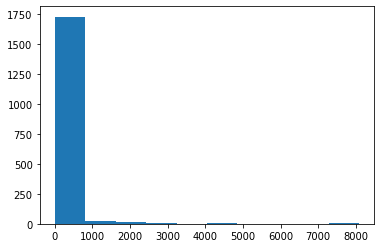

In [15]:
plt.hist(horses_clean['trainerName'].value_counts())
plt.show()

---